In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('voc_xywh.csv')
data = data.drop('Unnamed: 0', 1)
#data['File_Path'] = './VOCdevkit2007/VOC2007/JPEGImages/' + data['Frame']
#data = data[(data['label'] == 0)].reset_index()
print(data.head())

        Frame  x_center  y_center      w      h  label  type  \
0  003815.jpg     596.0     308.0  470.0  202.0    0.0  test   
1  003815.jpg     470.0      53.0   54.0  102.0    1.0  test   
2  003815.jpg     389.0      53.0   63.0  102.0    1.0  test   
3  003815.jpg     495.0     102.0   61.0  161.0    1.0  test   
4  003815.jpg     596.0     263.0   86.0   46.0    1.0  test   

                                        FileName  
0  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
1  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
2  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
3  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
4  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  


   index       Frame  x_center  y_center      w      h  label  type  \
0  16133  005926.jpg     493.0     337.0  825.0  605.0    1.0  test   
1  16134  005926.jpg      52.0     362.0   58.0   60.0    3.0  test   
2  16135  005926.jpg     832.0     304.0  147.0   70.0    8.0  test   

                                        FileName  
0  ./VOCdevkit2007/VOC2007/JPEGImages/005926.jpg  
1  ./VOCdevkit2007/VOC2007/JPEGImages/005926.jpg  
2  ./VOCdevkit2007/VOC2007/JPEGImages/005926.jpg  
[[  80.5   34.5  905.5  639.5]
 [  23.   332.    81.   392. ]
 [ 758.5  269.   905.5  339. ]]


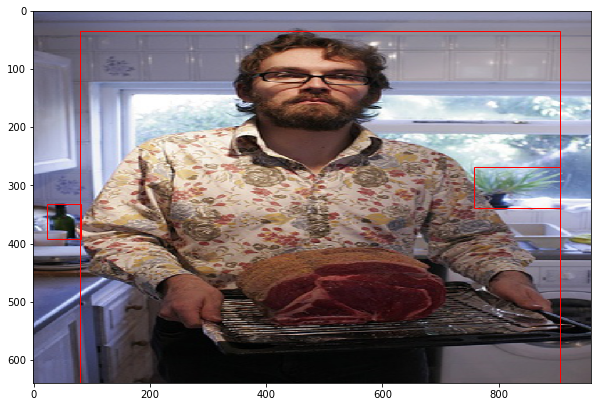

In [3]:
#This jupyter version only used on conv5-3, here I am not use multi-sclae features from different convolutional layer
import batch_generate
i_line = np.random.randint(len(data))
name_str, img, bb_boxes = batch_generate.get_img_by_name(data, i_line, size = (960, 640))
print(bb_boxes)
gta = batch_generate.bbox_transform(bb_boxes)
print(gta)
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
for i in range(len(gta)):
    currentAxis.add_patch(plt.Rectangle((gta[i,0], gta[i,1]), gta[i,2]-gta[i,0], gta[i,3]-gta[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [4]:
#Inference
import config
from netarch import *
img_channel_mean = [103.939, 116.779, 123.68]
with tf.Graph().as_default():
    mc = config.model_parameters()
    mc.LOAD_PRETRAINED_MODEL = False
    model = ResNet50(mc, '0')
    saver = tf.train.Saver(model.model_params)
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        saver.restore(sess, './tf_detection/model.ckpt-1000')
        img = img.astype(np.float32)
        img[:, :, 0] -= img_channel_mean[0]
        img[:, :, 1] -= img_channel_mean[1]
        img[:, :, 2] -= img_channel_mean[2]
        #img_per_batch = np.expand_dims(img, axis = 0)
        det_probs, det_boxes = sess.run([model.det_probs, model.det_boxes],feed_dict={model.image_input:[img], model.keep_prob: 1.0})

Input tensor shape to rpn: (1, 40, 60, 1024)
Input tensor shape to rpn_cls_score: (1, 40, 60, 512)
Input tensor shape to rpn_bbox_pred: (1, 40, 60, 512)


In [5]:
final_boxes, final_probs= model.filter_prediction(det_boxes[0], det_probs[0])

In [20]:
print(det_probs[0].shape)
tensor = det_probs[0]
tensor = tensor.reshape((40*60*9))
print(np.where(tensor < 0.1)[0])

(40, 60, 9)
[]
